In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
# Import models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
# Import model comparison metrics
from sklearn.metrics import mean_squared_error, auc, r2_score

In [4]:
# Import dataset

df = pd.read_csv('candy-data.csv')

In [5]:
df.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


In [6]:
df_clustering = df
df_regression = df.drop(columns= ['competitorname'])

In [8]:
df_regression

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [9]:
# List of independent variables
characteristics = ['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']

## kMeans

1. From the EDA, we realized that chocolate is a must have component for the new candy
2. fruity and chocolate do not got together
3. The candies at the bottom of the winpercent table are almost all 'pluribus' i.e. appearing as small candies in a packet
4. There are no hard candies in top performing candies
5. There are almost no bars in the bottom performing candies, but candies which are have 'bar' characteristic do appear in the top performing candies

Therefore, we drop these from our 

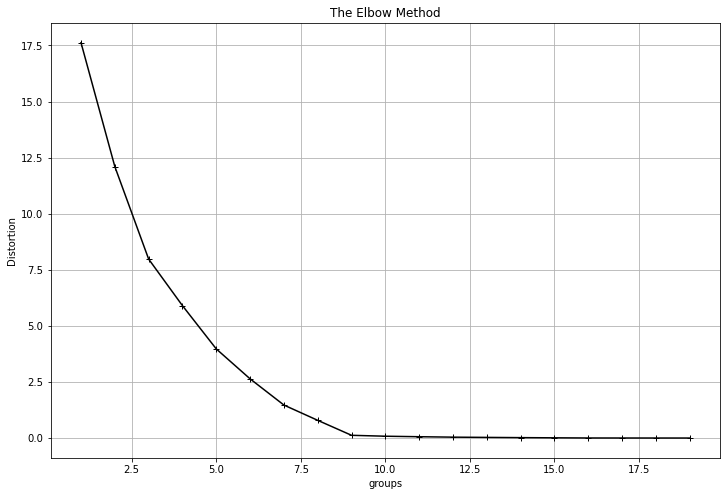

In [10]:
# K means clustering to find main combinations
k_labels = ["caramel", "peanutyalmondy", "nougat", "crispedricewafer", "winpercent"]

df_clustering = df_clustering.drop(["competitorname", "sugarpercent", "pricepercent"],axis=1)

df_clustering = df_clustering[(df_clustering["chocolate"] == 1) & (df_clustering["bar"] == 1) & (df_clustering["fruity"] == 0)]
df_clustering = df_clustering[k_labels]
df_clustering["winpercent"] = df_clustering["winpercent"]/100  # scale to fit categorical data distances

df_KMeans = df_clustering

## unique candy classes
unique_candy_classes = len(df_KMeans.drop_duplicates())

## elbow method
distortions = []
K = range(1,unique_candy_classes)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_KMeans)
    distortions.append(kmeanModel.inertia_)


# graphics
fig = plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.plot(K, distortions, '+-', color="black")
plt.xlabel('groups'); plt.ylabel('Distortion'); plt.grid(True)


plt.show()

according to the above graph, k = 9 is the ideal value

In [11]:
kmeanModel = KMeans(n_clusters=9)
kmeanModel.fit(df_KMeans)

df = pd.DataFrame (data=np.round(kmeanModel.cluster_centers_, 3), columns=k_labels)
df['winpercent'] = df['winpercent']*100  # unscale winpercent to range 0-100
print ('Main Candy subgroups\n')
df.sort_values('winpercent', ascending=False)

Main Candy subgroups



,caramel,peanutyalmondy,nougat,crispedricewafer,winpercent
2,1.0,0.0,0.0,1.0,74.3
5,0.0,0.0,0.0,1.0,68.5
6,1.0,0.0,1.0,0.0,67.0
3,1.0,1.0,1.0,0.0,66.8
8,1.0,0.0,0.0,0.0,64.4
7,1.0,1.0,0.0,1.0,59.5
4,0.0,1.0,0.0,0.0,58.5
0,0.0,0.0,1.0,0.0,53.3
1,0.0,0.0,0.0,0.0,53.3


According the k-means clustering, the best ingredients to build mixed chocolate bar are:
1. caramel
2. crispedricewafer
3. peanutyalmondy

# Linear Regression Analysis

In [23]:
X = df_regression.drop(['winpercent', 'sugarpercent', 'pricepercent'], axis=1)
y = df_regression['winpercent']

from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

In [24]:
X.shape

(85, 9)

In [27]:
y.shape

(85,)

In [31]:
from sklearn import linear_model # import.
lr_rdg = linear_model.Ridge(random_state=42) # instantiate.

# Perform cross-validation.
from sklearn.model_selection import GridSearchCV
hyperparameters = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
model_cv = GridSearchCV(estimator = lr_rdg, param_grid = hyperparameters, cv=10, scoring= 'neg_mean_absolute_error', return_train_score=True)
#lr_rdg.get_params().keys() # hyperparameters that we can set.

model_cv.fit(X, y) # fit.

GridSearchCV(cv=10, estimator=Ridge(random_state=123),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error')

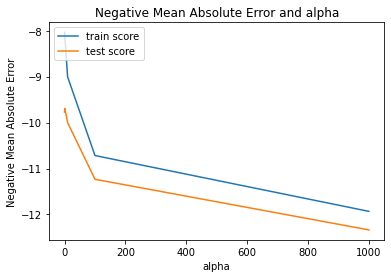

In [33]:
cv_results = pd.DataFrame(model_cv.cv_results_)
# cv_results.head()

# Plotting mean test and train scoes with alpha.
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# Plotting.
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [ ]:
model_cv.best_params_


{'alpha': 1}

In [34]:
alpha = 1
ridge = linear_model.Ridge(alpha=alpha)
ridge.fit(X, y)

Ridge(alpha=1)

In [35]:
ridge.intercept_ # constant term.

37.27885990571673

In [ ]:
for x,y in zip(X.columns, ridge.coef_): # coefficients of features.
    print(x, y*100)

In [37]:
for x,y in zip(X.columns, ridge.coef_): # coefficients of features.
    print(x, y)

chocolate 17.39511345084934
fruity 7.720639686401803
caramel 2.907233687069856
peanutyalmondy 9.09428184646823
nougat 1.3764952562193904
crispedricewafer 7.301821467840013
hard -4.442497827630218
bar 0.7309590882068222
pluribus -0.1423586756012258


# According to regression analysis, the recommendation for the new chocolate should be:

1. Chocolate
2. peanutyalmondy
3. crispedricewafer

Although, fruity characteristic is high, from the EDA, we know that chocolate and fruity are negatively correlated. Therefore, we do not consider fruity characteristic.

Final recommendations according to both analysis:

1. Chocolate
2. Peanut-almond-peanut_butter
3. Crisped rice wafer